# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [135]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import numpy as np

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [136]:
# files.upload()
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !pip install kaggle
# !kaggle datasets download -d datatattle/covid-19-nlp-text-classification

In [137]:
!unzip -o archive.zip -d covid_dataset

# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("covid_dataset/Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("covid_dataset/Corona_NLP_test.csv", encoding="latin1")

train.head()

Archive:  archive.zip
  inflating: covid_dataset/Corona_NLP_test.csv  
  inflating: covid_dataset/Corona_NLP_train.csv  


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [138]:
selected_features_train = train[['OriginalTweet', 'Sentiment']].copy()
selected_features_test = test[['OriginalTweet', 'Sentiment']].copy()

### b) Provjera nedostajućih vrijednosti

In [139]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [140]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima
# Provjera
print("Nedostajuće vrijednosti (Test):")
print(selected_features_test.isnull().sum())

# Brisanje redova s nedostajućim vrijednostima (ako ih ima)
selected_features_test.dropna(inplace=True)

Nedostajuće vrijednosti (Test):
OriginalTweet    0
Sentiment        0
dtype: int64


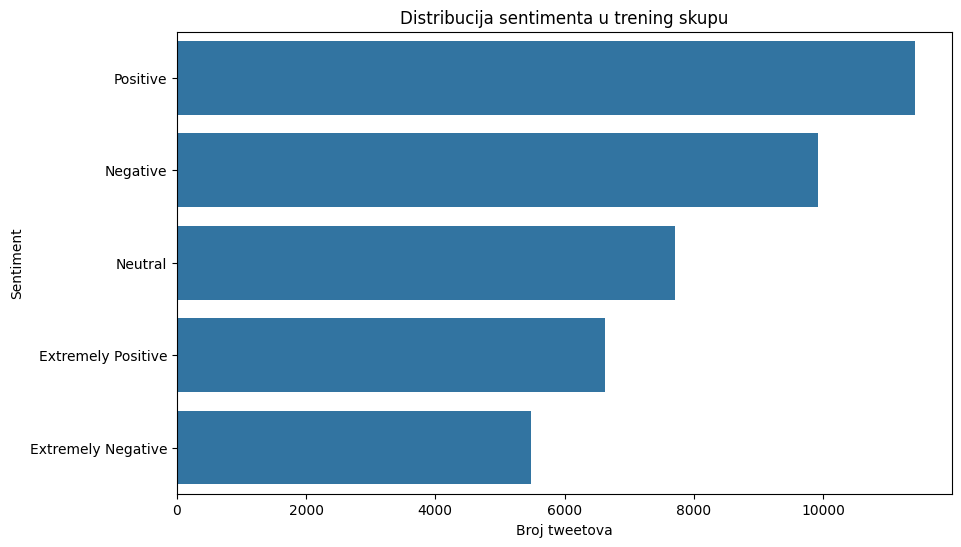

In [141]:
# ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke
plt.figure(figsize=(10, 6))
sns.countplot(y='Sentiment', data=selected_features_train, order=selected_features_train['Sentiment'].value_counts().index)
plt.title('Distribucija sentimenta u trening skupu')
plt.xlabel('Broj tweetova')
plt.show()

In [142]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

# ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja
print(selected_features_train['Sentiment'].value_counts())

Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64


### c) Lematizacija i čišćenje teksta

In [143]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [144]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  # tokenizacija, lematizacija i ponovno spajanje
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
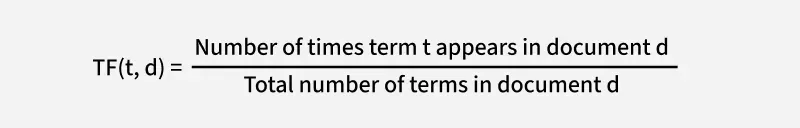

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
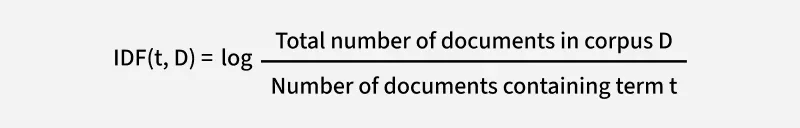

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [145]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
# ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [146]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [147]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train.values.ravel())

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6764586498292324


In [148]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train.values.ravel())

MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [149]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      1633
     Neutral       0.63      0.20      0.30       619
    Positive       0.63      0.81      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.57      0.58      3798
weighted avg       0.67      0.67      0.65      3798

Confusion Matrix:

[[1172   47  414]
 [ 192  122  305]
 [ 272   25 1249]]


## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [150]:
# inicijalizacija
svm_model = LinearSVC(random_state=42)

# Treniranje modela (y_train je DataFrame, pa koristimo .values.ravel() za pretvorbu u niz)
svm_model.fit(X_train, y_train.values.ravel())

y_pred_svm = svm_model.predict(X_test)

# Evaluacija
print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("SVM Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_svm))

SVM Classification Report:

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79      1633
     Neutral       0.66      0.64      0.65       619
    Positive       0.80      0.83      0.81      1546

    accuracy                           0.78      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.78      0.78      0.78      3798

SVM Confusion Matrix:

[[1266  132  235]
 [ 126  397   96]
 [ 185   73 1288]]


# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [151]:
!unzip -o ecommerce.zip -d ecommerce_dataset

# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
df = pd.read_csv("ecommerce_dataset/ecommerceDataset.csv", header=None, names=['label', 'text'])

train.head()

Archive:  ecommerce.zip
  inflating: ecommerce_dataset/ecommerceDataset.csv  


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [152]:
print("\nNedostajuće vrijednosti:\n", df.isnull().sum())


Nedostajuće vrijednosti:
 label    0
text     1
dtype: int64


In [153]:
print("Trenutni stupci:", df.columns)

Trenutni stupci: Index(['label', 'text'], dtype='object')


In [154]:
from nltk.corpus import stopwords

# Uklanjanje nedostajućih vrijednosti
df.dropna(inplace=True)

# Uklanjanje duplikata
df.drop_duplicates(inplace=True)
print(f"Broj redaka nakon čišćenja: {df.shape[0]}")

# Balansiranje - npr. 5000 uzoraka po klasi da ubrzamo treniranje
df = df.groupby('label').sample(n=5000, random_state=42)

# Funkcija za čišćenje
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(preprocess_text)

Broj redaka nakon čišćenja: 27802


In [155]:
# Enkodiranje labela
le = LabelEncoder()
y = le.fit_transform(df['label'])

# Training-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['clean_text'], y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)

print("Veličina trening matrice:", X_train.shape)
print("Klase:", le.classes_)

Veličina trening matrice: (16000, 5000)
Klase: ['Books' 'Clothing & Accessories' 'Electronics' 'Household']


--- Naive Bayes Rezultati ---
                        precision    recall  f1-score   support

                 Books       0.97      0.93      0.95      1000
Clothing & Accessories       0.96      0.98      0.97      1000
           Electronics       0.93      0.94      0.93      1000
             Household       0.90      0.93      0.91      1000

              accuracy                           0.94      4000
             macro avg       0.94      0.94      0.94      4000
          weighted avg       0.94      0.94      0.94      4000

SVM training

--- SVM (LinearSVC) Rezultati ---
                        precision    recall  f1-score   support

                 Books       0.97      0.94      0.95      1000
Clothing & Accessories       0.98      0.98      0.98      1000
           Electronics       0.95      0.94      0.95      1000
             Household       0.92      0.95      0.94      1000

              accuracy                           0.95      4000
             macro av

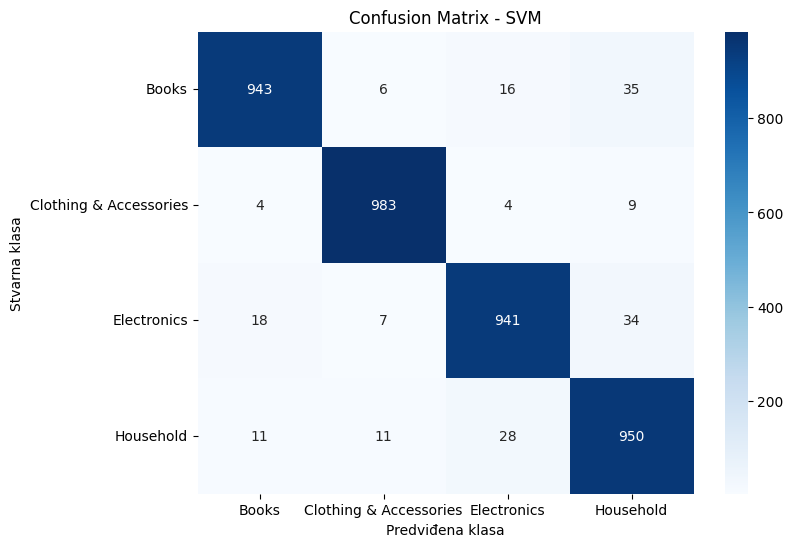

In [156]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("--- Naive Bayes Rezultati ---")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

# SVM - GridSearch
print("SVM training")
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print(f"\n--- SVM (LinearSVC) Rezultati ---")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Confusion Matrix za SVM
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - SVM')
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()

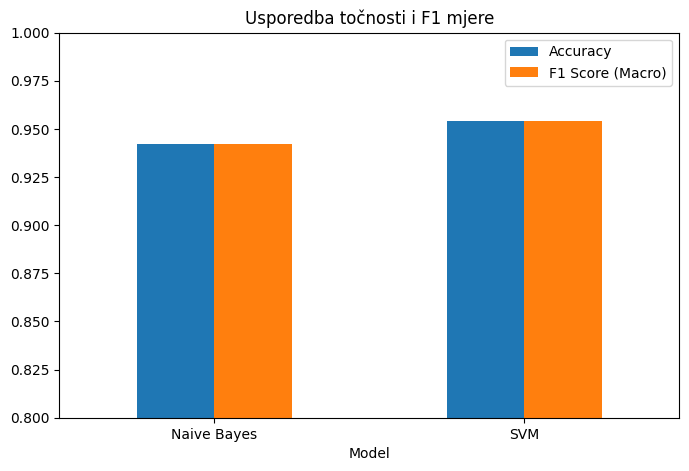

In [157]:
# Usporedba modela
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_svm)],
    'F1 Score (Macro)': [f1_score(y_test, y_pred_nb, average='macro'), f1_score(y_test, y_pred_svm, average='macro')]
})

results.plot(x='Model', kind='bar', figsize=(8, 5), rot=0)
plt.title('Usporedba točnosti i F1 mjere')
plt.ylim(0.8, 1.0)
plt.show()

In [158]:
# Prikaz top riječi po TF-IDF težini za svaku klasu
def print_top_words(model, feature_names, n_top_words=10):
    for i, class_label in enumerate(le.classes_):
        top_ids = np.argsort(model.coef_[i])[-n_top_words:]
        top_words = [feature_names[j] for j in top_ids]
        print(f"\nKlasa: {class_label}")
        print(f"Top riječi: {', '.join(top_words)}")

print("\n--- Najvažnije riječi za SVM model po klasama ---")
# LinearSVC coef_ je oblika (n_classes, n_features)
print_top_words(best_svm, tfidf.get_feature_names_out())


--- Najvažnije riječi za SVM model po klasama ---

Klasa: Books
Top riječi: film, game, guide, sketch, cue, book, climbing, society, fishing, author

Klasa: Clothing & Accessories
Top riječi: unisex, maternity, swimwear, breathable, girl, boy, bra, sunglass, men, womens

Klasa: Electronics
Top riječi: calculator, gb, charger, correction, lens, binoculars, screen, camera, laptop, trail

Klasa: Household
Top riječi: incense, safe, curtain, bathrobe, chair, pillow, oven, door, extended, vacuum


# Zaključak

**Koji model je bio bolji?** <br>
SVM (LinearSVC) je malo bolji - accuracy 0.95, naspram 0.94 kod Naive Bayesa. SVM se pokazao robusnijim u razdvajanju sličnih kategorija (npr. Household vs Electronics), i postigao je bolji F1-score.

**Prednosti i nedostaci pristupa:** <br>
Glavna prednost TF-IDF je brzina i visoka točnost (>94%) uz minimalne resurse. Glavni nedostatak je nepoznavanje konteksta, odnosno model gleda samo prisutnost riječi, a ne njihovo značenje ili redoslijed u rečenici.

**Ideje za poboljšanje:** <br>
Za dodatni napredak trebalo bi uključiti N-grame (kako bi model prepoznavao fraze poput "coffee maker") ili koristiti napredne Transformer modele (BERT) koji razumiju kontekst i nijanse jezika.

**Utjecaj predobrade:** <br>
Predobrada je bila ključna. Bez lematizacije (svođenja riječi na korijen) i uklanjanja stop-riječi, podaci bi bili puni šuma, a točnost modela bi vjerojatno pala ispod 90%.